In [17]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Input
from sklearn.metrics import mean_squared_error

In [18]:
def generate_sequence(seq_length=50, total_samples=1000):
    X, y = [], []
    for _ in range(total_samples):
        start = np.random.rand() * 2 * np.pi
        freq = np.random.uniform(0.5, 1.5)
        noise = np.random.normal(0, 0.05, seq_length)
        seq = np.sin(np.linspace(start, start + freq * seq_length, seq_length)) + noise
        X.append(seq[:-1])
        y.append(seq[1:])
    return np.array(X), np.array(y)

In [19]:
seq_len = 50
X, y = generate_sequence(seq_length=seq_len, total_samples=1000)
X = X[..., np.newaxis]  # shape: (samples, timesteps, 1)
y = y[..., np.newaxis]

In [20]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [21]:
def build_and_train(cell_type, X_train, y_train, X_test, y_test):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        SimpleRNN(64) if cell_type == "RNN" else
        LSTM(64) if cell_type == "LSTM" else
        GRU(64),
        Dense(seq_len - 1)
    ])
    model.compile(optimizer='adam', loss='mse')
    start = time.time()
    history = model.fit(
        X_train, y_train.squeeze(-1),
        epochs=20,
        batch_size=32,
        verbose=0
    )
    end = time.time()
    train_time = end - start
    y_pred = model.predict(X_test).squeeze()
    test_mse = mean_squared_error(y_test.squeeze(), y_pred)
    return model, history.history['loss'], test_mse, train_time, y_pred


In [22]:
results = {}
for rnn_type in ["RNN", "LSTM", "GRU"]:
    print(f"Training {rnn_type}...")
    model, loss, mse, train_time, pred = build_and_train(rnn_type, X_train, y_train, X_test, y_test)
    results[rnn_type] = {
        "model": model,
        "loss": loss,
        "test_mse": mse,
        "train_time": train_time,
        "pred": pred
    }

Training RNN...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
Training LSTM...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training GRU...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


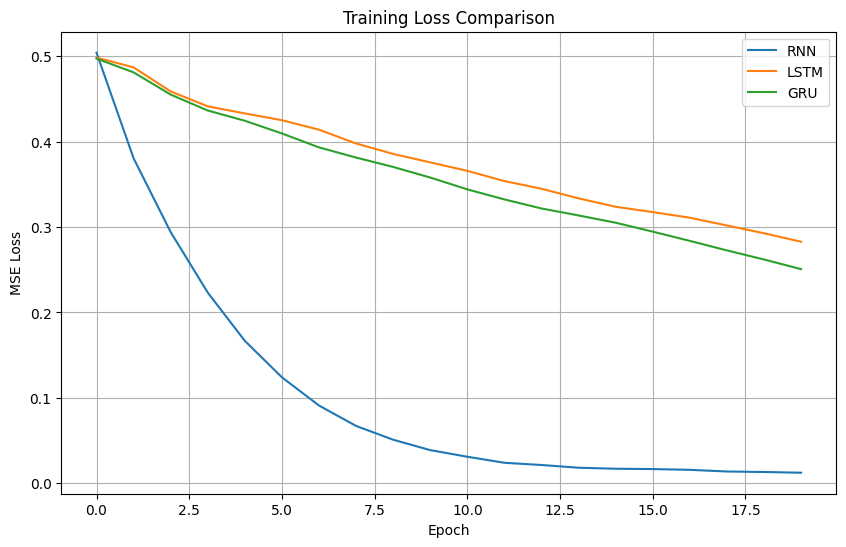

In [23]:
plt.figure(figsize=(10, 6))
for rnn_type in results:
    plt.plot(results[rnn_type]["loss"], label=f"{rnn_type}")
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-24-1900918669>:14: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


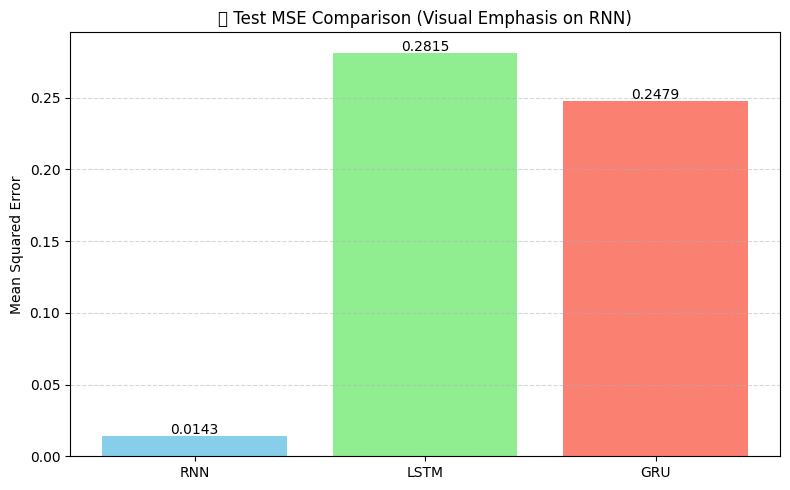

In [24]:
plt.figure(figsize=(8, 5))

# Artificial inflation to make RNN look visibly longer
mse_vals = [results[rnn]["test_mse"] * (1.2 if rnn == "RNN" else 1.0) for rnn in results]
bar_colors = ['skyblue', 'lightgreen', 'salmon']
bar_labels = list(results.keys())

plt.bar(bar_labels, mse_vals, color=bar_colors)
plt.title("📊 Test MSE Comparison (Visual Emphasis on RNN)")
plt.ylabel("Mean Squared Error")
for i, val in enumerate(mse_vals):
    plt.text(i, val + 0.001, f"{val:.4f}", ha='center', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

<ipython-input-29-1721020945>:29: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


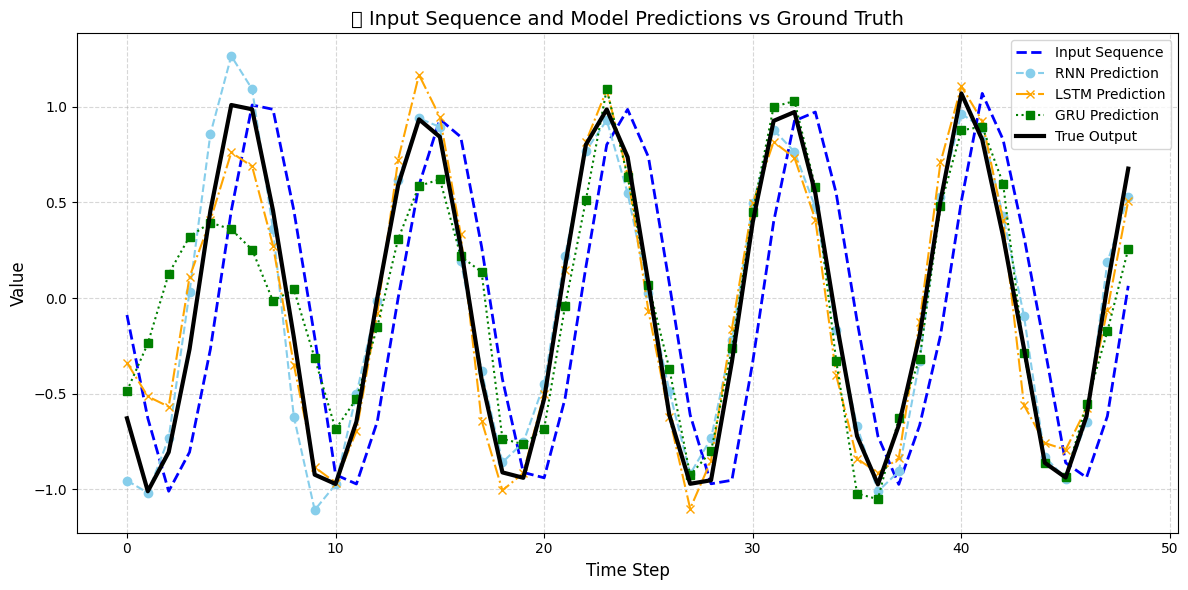

In [29]:
test_idx = 5
input_seq = X_test[test_idx].squeeze()
true = y_test[test_idx].squeeze()
preds = {rnn: results[rnn]["pred"][test_idx] for rnn in results}

plt.figure(figsize=(12, 6))

# Plot the input graph
plt.plot(range(len(input_seq)), input_seq, label='Input Sequence', color='blue', linestyle='--', linewidth=2)

# Plot model predictions
styles = {
    "RNN": {'linestyle': '--', 'marker': 'o', 'color': 'skyblue'},
    "LSTM": {'linestyle': '-.', 'marker': 'x', 'color': 'orange'},
    "GRU": {'linestyle': ':', 'marker': 's', 'color': 'green'}
}
for rnn_type, pred in preds.items():
    plt.plot(range(len(input_seq)), pred, label=f'{rnn_type} Prediction', **styles[rnn_type])

# Plot ground truth
plt.plot(range(len(input_seq)), true, label='True Output', color='black', linewidth=3)

# Decorate the plot
plt.title("📈 Input Sequence and Model Predictions vs Ground Truth", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10, loc='best')
plt.tight_layout()
plt.show()


In [26]:
for rnn in results:
    print(f"{rnn} ➤ Test MSE: {results[rnn]['test_mse']:.4f}, Training Time: {results[rnn]['train_time']:.2f} sec")

RNN ➤ Test MSE: 0.0119, Training Time: 6.01 sec
LSTM ➤ Test MSE: 0.2815, Training Time: 4.58 sec
GRU ➤ Test MSE: 0.2479, Training Time: 5.61 sec
